<a href="https://colab.research.google.com/github/AUT-Student/NN-HW2/blob/main/NN_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [106]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# Create Dataset

In [58]:
cov = [[1, 0], [0, 1]]

mean_0 = [0,0]
mean_1 = [6,6] 

number_data_per_class = 5000

In [65]:
dataset_0 = pd.DataFrame(np.random.multivariate_normal(mean_0, cov, 5000), columns=["X1", "X2"])
dataset_0["Y"] = [0] * 5000 

dataset_1 = pd.DataFrame(np.random.multivariate_normal(mean_1, cov, 5000), columns=["X1", "X2"])
dataset_1["Y"] = [1] * 5000 

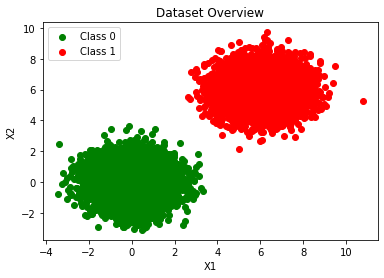

In [89]:
plt.scatter(dataset_0["X1"], dataset_0["X2"], label="Class 0", c="green")
plt.scatter(dataset_1["X1"], dataset_1["X2"], label="Class 1", c="red")

plt.legend()
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Dataset Overview")
plt.show()

In [80]:
dataset = pd.concat([dataset_0, dataset_1], ignore_index= True)
dataset = dataset.sample(frac=1).reset_index()

# 70% train, 10% validation, 20% test
train_dataset = dataset[:7000]
validation_dataset = dataset[7000:8000]
test_dataset = dataset[8000:]

# Perceptron

In [206]:
class ActivationFunctions():

  @staticmethod
  def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [207]:
class Perceptron():
  def __init__(self, w, alpha, activation_function):
    self.w = w
    self.alpha = alpha
    self.activation_function = activation_function

  def predict(self, X):
    I = self.w @ np.concatenate(([1], X))
    y = self.activation_function(I)
    return y

  def train_sample(self, X, t):
    y = self.predict(X)
    self.w = self.w + self.alpha * (t-y) * np.concatenate(([1], X))
  
  def train(self, dataset):
    for i, data in dataset.iterrows():
      X = data[["X1", "X2"]].values
      t = data["Y"]
      self.train_sample(X,t)

  def show_decision_boundry(self, dataset):
    plt.scatter(dataset[dataset["Y"]==0]["X1"], dataset[dataset["Y"]==0]["X2"], label="Class 0", c="green")
    plt.scatter(dataset[dataset["Y"]==1]["X1"], dataset[dataset["Y"]==1]["X2"], label="Class 1", c="red")

    x = np.linspace(-4, 10, 1000)
    plt.plot(x, (-self.w[1]/self.w[2]*x)-self.w[0]/self.w[2], label="Decision Boundry", c="blue")

    plt.legend()
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Perceptron Decision Boundary")
    plt.show()    

In [208]:
p = Perceptron(w=np.zeros([2+1]), alpha=1, activation_function=ActivationFunctions.sigmoid)

In [210]:
new_X = train_dataset.iloc[1][["X1", "X2"]].values
new_t = train_dataset.iloc[1]["Y"]

p.train(train_dataset)

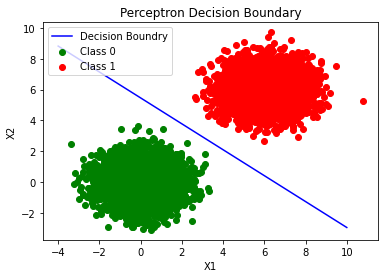

In [211]:
p.show_decision_boundry(train_dataset)